<a href="https://colab.research.google.com/github/Omerba31/Deep/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torchvision import transforms
import numpy as np
import random
from sklearn.cluster import DBSCAN


In [ ]:
#     Basic Definitions
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

eval_mode = False
epochs = 5
lr = 1e-3
batch_size = 128
embedding_dim = 64
triplet_alpha = 1.0  # Weight for Triplet Loss

num_ood_val = 300
num_ood_test = 800

Using device: cuda


In [ ]:
class CombinedDataset(Dataset):
    """
    Merges two datasets (MNIST for in-dist, and OOD) => label=10 for OOD
    """
    def __init__(self, ds_in, ds_ood):
        self.ds_in = ds_in
        self.ds_ood = ds_ood

    def __len__(self):
        return len(self.ds_in) + len(self.ds_ood)

    def __getitem__(self, idx):
        if idx < len(self.ds_in):
            data, label = self.ds_in[idx]
            return data, label
        else:
            data, _ = self.ds_ood[idx - len(self.ds_in)]
            return data, 10

In [ ]:
def eval_model(model, data_loader, device):
    """
    Evaluates an OSR model that outputs (N, 11) logits
    (10 known classes + 1 'unknown').
    Splits predictions for MNIST (label<10) vs OOD (label=10)
    and returns separate accuracies plus overall accuracy.
    """
    model.eval()
    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)  # shape (N,11)
            _, y_pred = torch.max(outputs, dim=1)

            mask_in = (labels < 10)
            mask_ood = (labels == 10)

            labels_in = labels[mask_in]
            labels_ood = labels[mask_ood]
            pred_in = y_pred[mask_in]
            pred_ood = y_pred[mask_ood]

            total_mnist += labels_in.size(0)
            correct_mnist += (pred_in == labels_in).sum().item()

            total_ood += labels_ood.size(0)
            correct_ood += (pred_ood == labels_ood).sum().item()

    acc_mnist = correct_mnist / total_mnist if total_mnist>0 else 0
    acc_ood   = correct_ood / total_ood     if total_ood>0   else 0
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)
    return acc_mnist, acc_ood, acc_total


In [ ]:
class CNN_EmbeddingNet_Triplet(nn.Module):
    def __init__(self, embedding_dim=64, dropout_p=0.3):
        super().__init__()
        self.device = device
        # Convs
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)

        # FC
        self.fc1 = nn.Linear(64*7*7, 128)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(128, embedding_dim)

        # Classifier
        self.classifier = nn.Linear(embedding_dim, 10)

    def forward_features(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        emb = self.fc2(x)
        return emb

    def forward_classifier(self, emb):
        return self.classifier(emb)

    def forward_inference_10(self, x):
        emb = self.forward_features(x)
        logits = self.forward_classifier(emb)
        return logits

    def forward(self, x):
        return self.forward_inference_10(x)


In [ ]:
def train_one_epoch_triplet(model, loader, optimizer, ce_criterion, triplet_margin=1.0, alpha=1.0):
    model.train()
    triplet_criterion = nn.TripletMarginLoss(margin=triplet_margin, reduction='mean')

    running_loss = 0.0
    running_ce   = 0.0
    running_trip = 0.0
    total_samples = 0
    correct = 0

    for data, labels in loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()

        logits = model.forward_inference_10(data)
        ce_loss = ce_criterion(logits, labels)

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

        emb = model.forward_features(data)

        anchor_list = []
        pos_list = []
        neg_list = []

        label2indices = {}
        for i, lab in enumerate(labels):
            lab_i = lab.item()
            label2indices.setdefault(lab_i, []).append(i)

        for i, lab in enumerate(labels):
            anchor_label = lab.item()
            if len(label2indices[anchor_label]) < 2:
                continue
            pos_idx = i
            while pos_idx == i:
                pos_idx = random.choice(label2indices[anchor_label])

            neg_label = anchor_label
            while neg_label == anchor_label:
                neg_label = random.choice(list(label2indices.keys()))
            neg_idx = random.choice(label2indices[neg_label])

            anchor_list.append(emb[i].unsqueeze(0))
            pos_list.append(emb[pos_idx].unsqueeze(0))
            neg_list.append(emb[neg_idx].unsqueeze(0))

        if len(anchor_list) > 0:
            anchor_t = torch.cat(anchor_list, dim=0)
            pos_t = torch.cat(pos_list, dim=0)
            neg_t = torch.cat(neg_list, dim=0)
            trip_loss = triplet_criterion(anchor_t, pos_t, neg_t)
        else:
            trip_loss = torch.tensor(0.0, device=device)

        total_loss = ce_loss + alpha*trip_loss
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item() * data.size(0)
        running_ce   += ce_loss.item() * data.size(0)
        running_trip += trip_loss.item() * data.size(0)

    ep_loss = running_loss / total_samples
    ep_ce   = running_ce / total_samples
    ep_trip = running_trip / total_samples
    ep_acc  = correct / total_samples
    return ep_loss, ep_ce, ep_trip, ep_acc


In [ ]:

def evaluate_classifier(model, loader, ce_criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in loader:
            data, labels = data.to(device), labels.to(device)
            logits = model.forward_inference_10(data)
            ce_loss = ce_criterion(logits, labels)

            total_loss += ce_loss.item() * data.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss/total, correct/total

In [ ]:
def compute_dbscan_clusters(model, dataset, eps, min_samples):
    """
    For each class c in 0..9, gather embeddings and run DBSCAN with (eps,min_samples).
    Return a dict c -> list of (centroid, radius) for each cluster.
    """
    model.eval()
    label2vecs = {c: [] for c in range(10)}

    loader = DataLoader(dataset, batch_size=256, shuffle=False)
    with torch.no_grad():
        for data, labels in loader:
            data, labels = data.to(device), labels.to(device)
            emb = model.forward_features(data)
            emb_np = emb.cpu().numpy()  # shape (B,embedding_dim)
            for i, lab in enumerate(labels):
                label2vecs[lab.item()].append(emb_np[i])

    dbscan_dict = {}
    for c in range(10):
        arr = np.vstack(label2vecs[c])  # (#samples_in_class,embedding_dim)
        if len(arr) == 0:
            dbscan_dict[c] = []
            continue

        dbs = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbs.fit_predict(arr)

        clusters_info = []
        unique_labels = set(cluster_labels) - {-1}
        for clab in unique_labels:
            points_in_cluster = arr[cluster_labels == clab]
            centroid = points_in_cluster.mean(axis=0)
            dists = np.sqrt(((points_in_cluster - centroid)**2).sum(axis=1))
            radius = dists.max()
            clusters_info.append({
                "centroid": centroid,
                "radius": radius
            })
        dbscan_dict[c] = clusters_info

    return dbscan_dict


In [ ]:
class OSRWrapperDBSCAN(nn.Module):
    def __init__(self, core_model, dbscan_dict, prob_threshold=0.7, dist_factor=1.0):
        """
        1) If maxProb < prob_threshold => unknown
        2) Else find nearest cluster (by centroid) in predicted class -> check distance < radius*dist_factor
        """
        super().__init__()
        self.core_model = core_model
        self.dbscan_dict = dbscan_dict
        self.prob_threshold = prob_threshold
        self.dist_factor = dist_factor

    def forward(self, x):
        emb = self.core_model.forward_features(x)
        logits_10 = self.core_model.forward_classifier(emb)
        probs_10 = F.softmax(logits_10, dim=1)

        out_11 = torch.zeros(x.size(0), 11, device=x.device)
        out_11[:, :10] = logits_10

        max_probs, pred_c = torch.max(probs_10, dim=1)
        emb_np = emb.detach().cpu().numpy()

        for i in range(x.size(0)):
            p = max_probs[i].item()
            c = pred_c[i].item()

            if p < self.prob_threshold:
                out_11[i, c] = -10.0
                out_11[i, 10] = 10.0
                continue

            clusters_info = self.dbscan_dict[c]
            if len(clusters_info) == 0:
                out_11[i, c] = -10.0
                out_11[i, 10] = 10.0
                continue

            sample_emb = emb_np[i]
            min_dist = 1e9
            best_rad = 0.0
            for info in clusters_info:
                centroid = info["centroid"]
                radius = info["radius"]
                dist = np.sqrt(((sample_emb - centroid)**2).sum())
                if dist < min_dist:
                    min_dist = dist
                    best_rad = radius

            if min_dist > best_rad*self.dist_factor:
                out_11[i, c] = -10.0
                out_11[i, 10] = 10.0
            else:
                out_11[i, 10] = -10.0

        return out_11

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
transform_test = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train_full = MNIST(root='./data', train=True, download=True, transform=transform_train)
mnist_test       = MNIST(root='./data', train=False, download=True, transform=transform_test)

val_ratio = 0.1
train_size = int((1 - val_ratio)*len(mnist_train_full))
val_size   = len(mnist_train_full) - train_size
mnist_train_ds, mnist_val_ds = random_split(mnist_train_full, [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)
mnist_val_ds.dataset.transform = transform_test

train_loader = DataLoader(mnist_train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(mnist_val_ds,   batch_size=batch_size, shuffle=False)

fashion_ds = FashionMNIST(root='./data', train=False, download=True, transform=transform_test)

inds = list(range(len(fashion_ds)))
random.shuffle(inds)
inds_val  = inds[:num_ood_val]
inds_test = inds[num_ood_val : num_ood_val + num_ood_test]

fashion_ood_val_ds  = Subset(fashion_ds, inds_val)
fashion_ood_test_ds = Subset(fashion_ds, inds_test)

val_ood_ds  = CombinedDataset(mnist_val_ds,  fashion_ood_val_ds)
test_ood_ds = CombinedDataset(mnist_test,    fashion_ood_test_ds)

val_ood_loader  = DataLoader(val_ood_ds,  batch_size=256, shuffle=False)
test_ood_loader = DataLoader(test_ood_ds, batch_size=256, shuffle=False)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:10<00:00, 903kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:06<00:00, 246kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.11MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 26.4M/26.4M [00:03<00:00, 7.79MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 142kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 2.65MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 12.4MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10, EMNIST

import numpy as np
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

batch_size = 128
num_ood_val = 300   # e.g. number of CIFAR samples for OOD validation
num_ood_test = 800  # e.g. number of CIFAR samples for OOD testing

# ======================================================================
#   CombinedDataset for OSR
# ======================================================================
class CombinedDataset(torch.utils.data.Dataset):
    """
    Merges two datasets: the first is 'in-dist' (label<10),
    the second is OOD (label=10).
    """
    def __init__(self, ds_in, ds_ood):
        self.ds_in = ds_in
        self.ds_ood = ds_ood

    def __len__(self):
        return len(self.ds_in) + len(self.ds_ood)

    def __getitem__(self, idx):
        if idx < len(self.ds_in):
            data, label = self.ds_in[idx]
            return data, label  # MNIST label
        else:
            data, _ = self.ds_ood[idx - len(self.ds_in)]
            return data, 10     # OOD label => 10

# ======================================================================
#   Transforms
# ======================================================================
# For MNIST:
transform_mnist_train = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
transform_mnist_test = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# For CIFAR10 -> to grayscale, resize 28x28, then normalize similarly
transform_cifar = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(num_output_channels=1),  # from RGB to 1 channel
    transforms.ToTensor(),
    # We can reuse the same mean/std as MNIST or recalc. We'll do the same for simplicity:
    transforms.Normalize((0.1307,), (0.3081,))
])

# ======================================================================
#   Loading MNIST as in-dist
# ======================================================================
mnist_train_full = MNIST(root='./data', train=True, download=True, transform=transform_mnist_train)
mnist_test       = MNIST(root='./data', train=False, download=True, transform=transform_mnist_test)

# We define a validation split from the training data
val_ratio = 0.1
train_size = int((1 - val_ratio)*len(mnist_train_full))
val_size   = len(mnist_train_full) - train_size
mnist_train_ds, mnist_val_ds = torch.utils.data.random_split(
    mnist_train_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)
# override transform for val set:
mnist_val_ds.dataset.transform = transform_mnist_test

train_loader = DataLoader(mnist_train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(mnist_val_ds,   batch_size=batch_size, shuffle=False)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# ======================================================================
#   Loading CIFAR10 as OOD
# ======================================================================
cifar_test = CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
# cifar_test = EMNIST(root="./data",
#                       split="balanced",  # או 'byclass', 'bymerge', etc.
#                       train=False,
#                       download=True,
#                       transform=transform_cifar)

inds = list(range(len(cifar_test)))
random.shuffle(inds)

# separate: OOD for val, OOD for test
inds_ood_val  = inds[:num_ood_val]
inds_ood_test = inds[num_ood_val : num_ood_val + num_ood_test]

cifar_ood_val_ds  = Subset(cifar_test, inds_ood_val)
cifar_ood_test_ds = Subset(cifar_test, inds_ood_test)

# Combined datasets for OSR
val_ood_ds  = CombinedDataset(mnist_val_ds,  cifar_ood_val_ds)
test_ood_ds = CombinedDataset(mnist_test,    cifar_ood_test_ds)

val_ood_loader  = DataLoader(val_ood_ds,  batch_size=256, shuffle=False)
test_ood_loader = DataLoader(test_ood_ds, batch_size=256, shuffle=False)

print("Datasets loaded. MNIST + CIFAR10 as OOD.")
fashion_ds = cifar_test
fashion_ood_val_ds  = cifar_ood_val_ds
fashion_ood_test_ds = cifar_ood_test_ds

Device: cuda


100%|██████████| 170M/170M [00:14<00:00, 11.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Datasets loaded. MNIST + CIFAR10 as OOD.


In [ ]:
core_model = CNN_EmbeddingNet_Triplet(embedding_dim=embedding_dim, dropout_p=0.3).to(device)
optimizer = optim.Adam(core_model.parameters(), lr=lr)
ce_criterion = nn.CrossEntropyLoss()

if not eval_mode:
    print("=== Training CNN Embedding Model (Triplet+CE) on MNIST ===")
    for ep in range(1, epochs+1):
        total_loss, ce_val, trip_val, train_acc = train_one_epoch_triplet(
            core_model, train_loader, optimizer, ce_criterion,
            triplet_margin=1.0, alpha=triplet_alpha
        )
        val_loss, val_acc = evaluate_classifier(core_model, val_loader, ce_criterion)
        print(f"Epoch {ep}/{epochs} | "
              f"TrainLoss={total_loss:.4f} (CE={ce_val:.4f}, T={trip_val:.4f}), "
              f"Acc={train_acc:.4f} | ValLoss={val_loss:.4f}, ValAcc={val_acc:.4f}")

    torch.save(core_model.state_dict(), "mnist_cnn_triplet_dbscan_tuning.pth")
    print("Saved weights to mnist_cnn_triplet_dbscan_tuning.pth")
else:
    core_model.load_state_dict(torch.load("mnist_cnn_triplet_dbscan_tuning.pth", map_location=device))
    print("Loaded weights from mnist_cnn_triplet_dbscan_tuning.pth")



=== Training CNN Embedding Model (Triplet+CE) on MNIST ===
Epoch 1/5 | TrainLoss=0.4315 (CE=0.2812, T=0.1503), Acc=0.9152 | ValLoss=0.0662, ValAcc=0.9822
Epoch 2/5 | TrainLoss=0.1181 (CE=0.0739, T=0.0442), Acc=0.9774 | ValLoss=0.0479, ValAcc=0.9863
Epoch 3/5 | TrainLoss=0.0837 (CE=0.0522, T=0.0315), Acc=0.9846 | ValLoss=0.0472, ValAcc=0.9863
Epoch 4/5 | TrainLoss=0.0692 (CE=0.0429, T=0.0264), Acc=0.9875 | ValLoss=0.0425, ValAcc=0.9872
Epoch 5/5 | TrainLoss=0.0612 (CE=0.0364, T=0.0249), Acc=0.9892 | ValLoss=0.0434, ValAcc=0.9883
Saved weights to mnist_cnn_triplet_dbscan_tuning.pth


In [ ]:
eps_grid = [1.5, 2.0, 2.5]
min_samples_grid = [3, 5]
prob_grid = [0.6, 0.7, 0.8]
dist_factor_grid = [1.0, 1.2]

best_config = None
best_acc = 0.0

print("\n=== Hyperparameter Tuning over DBSCAN + prob_threshold + dist_factor ===")
for eps_val in eps_grid:
    for min_s in min_samples_grid:
        # compute DBSCAN clusters for this combination
        dbscan_dict = compute_dbscan_clusters(core_model, mnist_train_ds, eps=eps_val, min_samples=min_s)

        for prob_t in prob_grid:
            for dist_f in dist_factor_grid:
                # build a wrapper model
                temp_model = OSRWrapperDBSCAN(
                    core_model,
                    dbscan_dict,
                    prob_threshold=prob_t,
                    dist_factor=dist_f
                ).to(device)

                acc_mnist, acc_ood, acc_total = eval_model(temp_model, val_ood_loader, device)

                if acc_total > best_acc:
                    best_acc = acc_total
                    best_config = (eps_val, min_s, prob_t, dist_f)
                    print(f"New best: eps={eps_val}, minS={min_s}, prob={prob_t}, distF={dist_f}, valAcc={acc_total*100:.2f}%")

eps_best, min_s_best, prob_best, dist_f_best = best_config
print(f"\nBest config = eps={eps_best}, min_samples={min_s_best}, prob={prob_best}, dist_factor={dist_f_best}, valAcc={best_acc*100:.2f}%")



=== Hyperparameter Tuning over DBSCAN + prob_threshold + dist_factor ===
New best: eps=1.5, minS=3, prob=0.6, distF=1.0, valAcc=37.48%
New best: eps=1.5, minS=3, prob=0.6, distF=1.2, valAcc=38.78%
New best: eps=1.5, minS=5, prob=0.6, distF=1.0, valAcc=54.70%
New best: eps=1.5, minS=5, prob=0.6, distF=1.2, valAcc=56.98%
New best: eps=2.0, minS=3, prob=0.6, distF=1.0, valAcc=68.32%
New best: eps=2.0, minS=3, prob=0.6, distF=1.2, valAcc=68.95%
New best: eps=2.0, minS=5, prob=0.6, distF=1.0, valAcc=84.94%
New best: eps=2.0, minS=5, prob=0.6, distF=1.2, valAcc=86.68%
New best: eps=2.5, minS=5, prob=0.6, distF=1.0, valAcc=91.00%
New best: eps=2.5, minS=5, prob=0.6, distF=1.2, valAcc=91.52%

Best config = eps=2.5, min_samples=5, prob=0.6, dist_factor=1.2, valAcc=91.52%


In [ ]:
#  compute DBSCAN again with best config, and evaluate on test set
dbscan_dict_final = compute_dbscan_clusters(core_model, mnist_train_ds, eps=eps_best, min_samples=min_s_best)
final_model = OSRWrapperDBSCAN(core_model, dbscan_dict_final, prob_threshold=prob_best, dist_factor=dist_f_best).to(device)

acc_mnist_test, acc_ood_test, acc_total_test = eval_model(final_model, test_ood_loader, device)
print("\n=== Final OSR (with best config) on Test ===")
print(f"Accuracy on MNIST: {acc_mnist_test*100:.2f}%")
print(f"Accuracy on OOD:   {acc_ood_test*100:.2f}%")
print(f"Total Accuracy:    {acc_total_test*100:.2f}%")

print("Done.")



=== Final OSR (with best config) on Test ===
Accuracy on MNIST: 91.65%
Accuracy on OOD:   100.00%
Total Accuracy:    92.27%
Done.


Using device: cuda
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.16MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 170M/170M [00:04<00:00, 34.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Datasets loaded. MNIST + CIFAR10 as OOD.
=== Training CNN Embedding Model (Triplet + CE) on MNIST ===
Epoch 1/5 | TrainLoss=0.4310 (CE=0.2809, T=0.1501), Acc=0.9156 | ValLoss=0.0666, ValAcc=0.9822
Epoch 2/5 | TrainLoss=0.1203 (CE=0.0747, T=0.0457), Acc=0.9781 | ValLoss=0.0480, ValAcc=0.9850
Epoch 3/5 | TrainLoss=0.0861 (CE=0.0531, T=0.0330), Acc=0.9847 | ValLoss=0.0430, ValAcc=0.9867
Epoch 4/5 | TrainLoss=0.0677 (CE=0.0425, T=0.0252), Acc=0.9872 | ValLoss=0.0383, ValAcc=0.9878
Epoch 5/5 | TrainLoss=0.0603 (CE=0.0357, T=0.0246), Acc=0.9889 | ValLoss=0.0377, ValAcc=0.9878
Saved weights to mnist_cnn_triplet_dbscan_tuning.pth


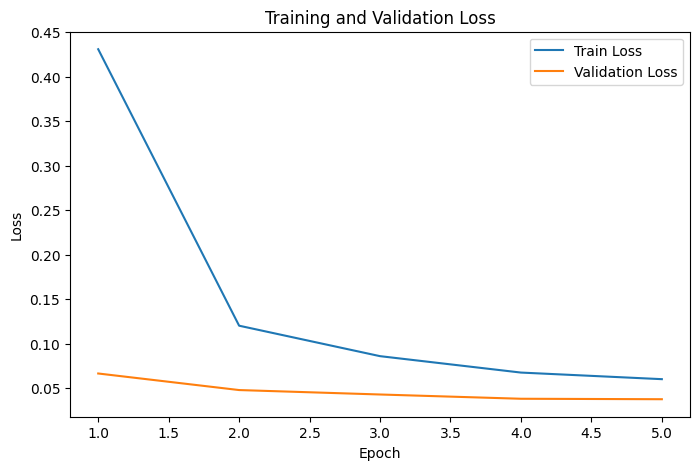


=== Hyperparameter Tuning over DBSCAN + prob_threshold + dist_factor ===
New best: eps=1.5, minS=3, prob=0.6, distF=1.0, valAcc=34.59%
New best: eps=1.5, minS=3, prob=0.6, distF=1.2, valAcc=36.48%
New best: eps=1.5, minS=5, prob=0.6, distF=1.0, valAcc=48.62%
New best: eps=1.5, minS=5, prob=0.6, distF=1.2, valAcc=50.21%
New best: eps=2.0, minS=3, prob=0.6, distF=1.0, valAcc=66.51%
New best: eps=2.0, minS=3, prob=0.6, distF=1.2, valAcc=67.00%
New best: eps=2.0, minS=5, prob=0.6, distF=1.0, valAcc=77.40%
New best: eps=2.0, minS=5, prob=0.6, distF=1.2, valAcc=78.22%
New best: eps=2.5, minS=3, prob=0.6, distF=1.0, valAcc=83.83%
New best: eps=2.5, minS=3, prob=0.6, distF=1.2, valAcc=84.25%
New best: eps=2.5, minS=5, prob=0.6, distF=1.0, valAcc=91.03%
New best: eps=2.5, minS=5, prob=0.6, distF=1.2, valAcc=91.70%

Best config = eps=2.5, min_samples=5, prob=0.6, dist_factor=1.2, valAcc=91.70%

=== Final OSR (with best config) on Test Set ===
Accuracy on MNIST (in-dist): 91.45%
Accuracy on OOD:

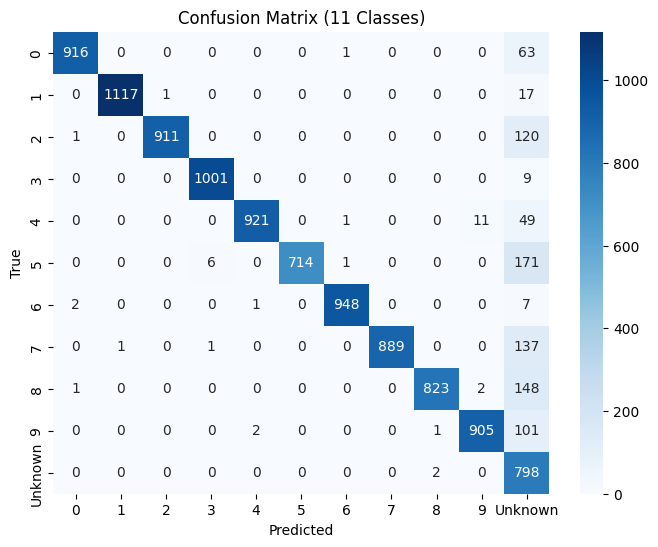

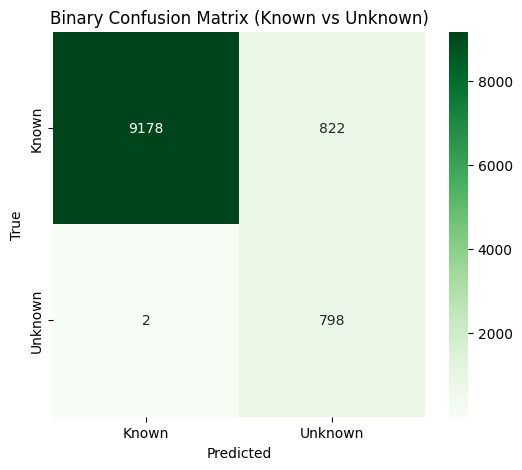

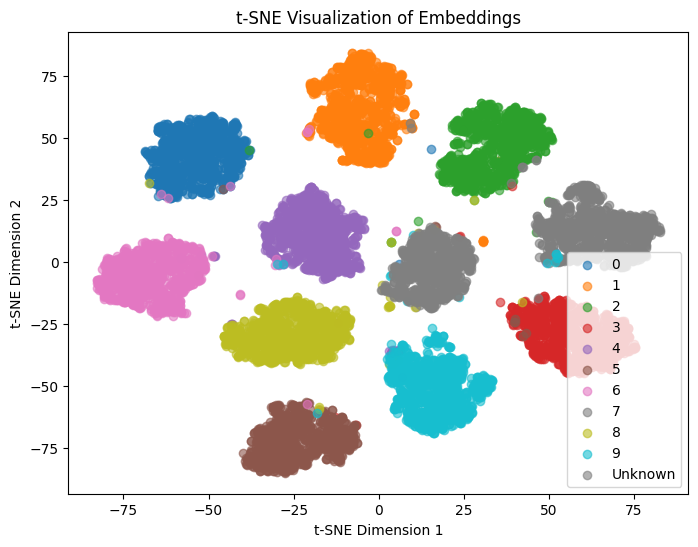

Done.


In [1]:
#%%
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision.datasets import MNIST, CIFAR10, FashionMNIST
from torchvision import transforms
import numpy as np
import random
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#%%
# Basic Definitions and Setup
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

eval_mode = False       # Set to True for evaluation only
epochs = 5              # Adjust as needed (should be under 10 minutes)
lr = 1e-3
batch_size = 128
embedding_dim = 64
triplet_alpha = 1.0     # Weight for Triplet Loss

# Number of OOD samples for validation and testing
num_ood_val = 300
num_ood_test = 800

#%%
# CombinedDataset: Merges two datasets (in-dist and OOD).
# OOD samples are assigned label 10.
class CombinedDataset(Dataset):
    """
    Merges two datasets (in-dist and OOD) where the OOD samples receive label 10.
    """
    def __init__(self, ds_in, ds_ood):
        self.ds_in = ds_in
        self.ds_ood = ds_ood

    def __len__(self):
        return len(self.ds_in) + len(self.ds_ood)

    def __getitem__(self, idx):
        if idx < len(self.ds_in):
            data, label = self.ds_in[idx]
            return data, label
        else:
            data, _ = self.ds_ood[idx - len(self.ds_in)]
            return data, 10

#%%
def eval_model(model, data_loader, device):
    """
    Evaluates an OSR model that outputs (N, 11) logits (10 known classes + 1 'unknown').
    Returns accuracy on in-dist (MNIST), OOD, and overall.
    """
    model.eval()
    correct_in = 0
    total_in = 0
    correct_ood = 0
    total_ood = 0

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)  # Expected shape (N, 11)
            _, y_pred = torch.max(outputs, dim=1)

            mask_in = (labels < 10)
            mask_ood = (labels == 10)

            labels_in = labels[mask_in]
            labels_ood = labels[mask_ood]
            pred_in = y_pred[mask_in]
            pred_ood = y_pred[mask_ood]

            total_in += labels_in.size(0)
            correct_in += (pred_in == labels_in).sum().item()

            total_ood += labels_ood.size(0)
            correct_ood += (pred_ood == labels_ood).sum().item()

    acc_in = correct_in / total_in if total_in > 0 else 0
    acc_ood = correct_ood / total_ood if total_ood > 0 else 0
    acc_total = (correct_in + correct_ood) / (total_in + total_ood)
    return acc_in, acc_ood, acc_total

#%%
# CNN with Embedding Network and Triplet Loss
class CNN_EmbeddingNet_Triplet(nn.Module):
    def __init__(self, embedding_dim=64, dropout_p=0.3):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers for embedding
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(128, embedding_dim)

        # Classifier for 10 known classes
        self.classifier = nn.Linear(embedding_dim, 10)

    def forward_features(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        emb = self.fc2(x)
        return emb

    def forward_classifier(self, emb):
        return self.classifier(emb)

    def forward_inference_10(self, x):
        emb = self.forward_features(x)
        logits = self.forward_classifier(emb)
        return logits

    def forward(self, x):
        return self.forward_inference_10(x)

#%%
def train_one_epoch_triplet(model, loader, optimizer, ce_criterion, triplet_margin=1.0, alpha=1.0):
    model.train()
    triplet_criterion = nn.TripletMarginLoss(margin=triplet_margin, reduction='mean')

    running_loss = 0.0
    running_ce = 0.0
    running_trip = 0.0
    total_samples = 0
    correct = 0

    for data, labels in loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass for classification
        logits = model.forward_inference_10(data)
        ce_loss = ce_criterion(logits, labels)

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

        # Forward pass for embeddings
        emb = model.forward_features(data)

        # Create triplets for triplet loss
        anchor_list, pos_list, neg_list = [], [], []
        label2indices = {}
        for i, lab in enumerate(labels):
            lab_i = lab.item()
            label2indices.setdefault(lab_i, []).append(i)

        for i, lab in enumerate(labels):
            anchor_label = lab.item()
            if len(label2indices[anchor_label]) < 2:
                continue
            pos_idx = i
            while pos_idx == i:
                pos_idx = random.choice(label2indices[anchor_label])
            neg_label = anchor_label
            while neg_label == anchor_label:
                neg_label = random.choice(list(label2indices.keys()))
            neg_idx = random.choice(label2indices[neg_label])

            anchor_list.append(emb[i].unsqueeze(0))
            pos_list.append(emb[pos_idx].unsqueeze(0))
            neg_list.append(emb[neg_idx].unsqueeze(0))

        if len(anchor_list) > 0:
            anchor_t = torch.cat(anchor_list, dim=0)
            pos_t = torch.cat(pos_list, dim=0)
            neg_t = torch.cat(neg_list, dim=0)
            trip_loss = triplet_criterion(anchor_t, pos_t, neg_t)
        else:
            trip_loss = torch.tensor(0.0, device=device)

        total_loss = ce_loss + alpha * trip_loss
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item() * data.size(0)
        running_ce += ce_loss.item() * data.size(0)
        running_trip += trip_loss.item() * data.size(0)

    ep_loss = running_loss / total_samples
    ep_ce = running_ce / total_samples
    ep_trip = running_trip / total_samples
    ep_acc = correct / total_samples
    return ep_loss, ep_ce, ep_trip, ep_acc

#%%
def evaluate_classifier(model, loader, ce_criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in loader:
            data, labels = data.to(device), labels.to(device)
            logits = model.forward_inference_10(data)
            ce_loss = ce_criterion(logits, labels)
            total_loss += ce_loss.item() * data.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

#%%
def compute_dbscan_clusters(model, dataset, eps, min_samples):
    """
    For each class (0..9), gather embeddings and run DBSCAN (with eps and min_samples).
    Returns a dictionary mapping class -> list of clusters (each cluster has a centroid and a radius).
    """
    model.eval()
    label2vecs = {c: [] for c in range(10)}

    loader = DataLoader(dataset, batch_size=256, shuffle=False)
    with torch.no_grad():
        for data, labels in loader:
            data, labels = data.to(device), labels.to(device)
            emb = model.forward_features(data)
            emb_np = emb.cpu().numpy()  # shape (B, embedding_dim)
            for i, lab in enumerate(labels):
                label2vecs[lab.item()].append(emb_np[i])

    dbscan_dict = {}
    for c in range(10):
        arr = np.vstack(label2vecs[c])
        if len(arr) == 0:
            dbscan_dict[c] = []
            continue
        dbs = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbs.fit_predict(arr)
        clusters_info = []
        unique_labels = set(cluster_labels) - {-1}
        for clab in unique_labels:
            points = arr[cluster_labels == clab]
            centroid = points.mean(axis=0)
            dists = np.sqrt(((points - centroid) ** 2).sum(axis=1))
            radius = dists.max()
            clusters_info.append({"centroid": centroid, "radius": radius})
        dbscan_dict[c] = clusters_info
    return dbscan_dict

#%%
class OSRWrapperDBSCAN(nn.Module):
    def __init__(self, core_model, dbscan_dict, prob_threshold=0.7, dist_factor=1.0):
        """
        1) If max probability < prob_threshold, classify as unknown.
        2) Otherwise, for the predicted class, check the distance of the sample's embedding
           to the nearest cluster. If the distance exceeds (radius * dist_factor), mark as unknown.
        """
        super().__init__()
        self.core_model = core_model
        self.dbscan_dict = dbscan_dict
        self.prob_threshold = prob_threshold
        self.dist_factor = dist_factor

    def forward(self, x):
        emb = self.core_model.forward_features(x)
        logits_10 = self.core_model.forward_classifier(emb)
        probs_10 = F.softmax(logits_10, dim=1)

        # Prepare output logits for 11 classes: copy known class logits and reserve slot 10 for unknown.
        out_11 = torch.zeros(x.size(0), 11, device=x.device)
        out_11[:, :10] = logits_10

        max_probs, pred_class = torch.max(probs_10, dim=1)
        emb_np = emb.detach().cpu().numpy()

        for i in range(x.size(0)):
            p = max_probs[i].item()
            c = pred_class[i].item()
            if p < self.prob_threshold:
                out_11[i, c] = -10.0
                out_11[i, 10] = 10.0
                continue

            clusters_info = self.dbscan_dict[c]
            if len(clusters_info) == 0:
                out_11[i, c] = -10.0
                out_11[i, 10] = 10.0
                continue

            sample_emb = emb_np[i]
            min_dist = 1e9
            best_radius = 0.0
            for info in clusters_info:
                centroid = info["centroid"]
                radius = info["radius"]
                dist = np.sqrt(((sample_emb - centroid) ** 2).sum())
                if dist < min_dist:
                    min_dist = dist
                    best_radius = radius
            if min_dist > best_radius * self.dist_factor:
                out_11[i, c] = -10.0
                out_11[i, 10] = 10.0
            else:
                out_11[i, 10] = -10.0

        return out_11

#%%
# Data Transforms
# For MNIST (in-distribution)
transform_mnist_train = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
transform_mnist_test = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# For CIFAR10 (OOD): convert RGB to grayscale, resize, and normalize
transform_cifar = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

#%%
# Load MNIST as in-distribution data
mnist_train_full = MNIST(root='./data', train=True, download=True, transform=transform_mnist_train)
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform_mnist_test)

# Create a validation split from MNIST training data (90%-10%)
val_ratio = 0.1
train_size = int((1 - val_ratio) * len(mnist_train_full))
val_size = len(mnist_train_full) - train_size
mnist_train_ds, mnist_val_ds = random_split(
    mnist_train_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)
mnist_val_ds.dataset.transform = transform_mnist_test

train_loader = DataLoader(mnist_train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mnist_val_ds, batch_size=batch_size, shuffle=False)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

#%%
# Load CIFAR10 as OOD data using CIFAR transform
cifar_test = CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

inds = list(range(len(cifar_test)))
random.shuffle(inds)
inds_ood_val = inds[:num_ood_val]
inds_ood_test = inds[num_ood_val : num_ood_val + num_ood_test]

cifar_ood_val_ds = Subset(cifar_test, inds_ood_val)
cifar_ood_test_ds = Subset(cifar_test, inds_ood_test)

# Create combined datasets for OSR evaluation (in-dist + OOD)
val_ood_ds = CombinedDataset(mnist_val_ds, cifar_ood_val_ds)
test_ood_ds = CombinedDataset(mnist_test, cifar_ood_test_ds)

val_ood_loader = DataLoader(val_ood_ds, batch_size=256, shuffle=False)
test_ood_loader = DataLoader(test_ood_ds, batch_size=256, shuffle=False)

print("Datasets loaded. MNIST + CIFAR10 as OOD.")

#%%
# Initialize core model and optimizer
core_model = CNN_EmbeddingNet_Triplet(embedding_dim=embedding_dim, dropout_p=0.3).to(device)
optimizer = optim.Adam(core_model.parameters(), lr=lr)
ce_criterion = nn.CrossEntropyLoss()

# Lists to store training and validation losses for plotting
train_losses = []
val_losses = []

if not eval_mode:
    print("=== Training CNN Embedding Model (Triplet + CE) on MNIST ===")
    for ep in range(1, epochs + 1):
        total_loss, ce_loss_val, trip_loss_val, train_acc = train_one_epoch_triplet(
            core_model, train_loader, optimizer, ce_criterion,
            triplet_margin=1.0, alpha=triplet_alpha
        )
        val_loss, val_acc = evaluate_classifier(core_model, val_loader, ce_criterion)
        train_losses.append(total_loss)
        val_losses.append(val_loss)
        print(f"Epoch {ep}/{epochs} | TrainLoss={total_loss:.4f} (CE={ce_loss_val:.4f}, T={trip_loss_val:.4f}), Acc={train_acc:.4f} | ValLoss={val_loss:.4f}, ValAcc={val_acc:.4f}")
    torch.save(core_model.state_dict(), "mnist_cnn_triplet_dbscan_tuning.pth")
    print("Saved weights to mnist_cnn_triplet_dbscan_tuning.pth")
else:
    core_model.load_state_dict(torch.load("mnist_cnn_triplet_dbscan_tuning.pth", map_location=device))
    print("Loaded weights from mnist_cnn_triplet_dbscan_tuning.pth")

#%%
# Plot Training and Validation Losses (if training was performed)
if not eval_mode:
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

#%%
# Hyperparameter tuning for DBSCAN + probability threshold + distance factor
eps_grid = [1.5, 2.0, 2.5]
min_samples_grid = [3, 5]
prob_grid = [0.6, 0.7, 0.8]
dist_factor_grid = [1.0, 1.2]

best_config = None
best_acc = 0.0

print("\n=== Hyperparameter Tuning over DBSCAN + prob_threshold + dist_factor ===")
for eps_val in eps_grid:
    for min_s in min_samples_grid:
        # Compute DBSCAN clusters for this combination using the MNIST training set
        dbscan_dict = compute_dbscan_clusters(core_model, mnist_train_ds, eps=eps_val, min_samples=min_s)
        for prob_t in prob_grid:
            for dist_f in dist_factor_grid:
                temp_model = OSRWrapperDBSCAN(
                    core_model,
                    dbscan_dict,
                    prob_threshold=prob_t,
                    dist_factor=dist_f
                ).to(device)
                acc_in, acc_ood, acc_total = eval_model(temp_model, val_ood_loader, device)
                if acc_total > best_acc:
                    best_acc = acc_total
                    best_config = (eps_val, min_s, prob_t, dist_f)
                    print(f"New best: eps={eps_val}, minS={min_s}, prob={prob_t}, distF={dist_f}, valAcc={acc_total*100:.2f}%")

eps_best, min_s_best, prob_best, dist_f_best = best_config
print(f"\nBest config = eps={eps_best}, min_samples={min_s_best}, prob={prob_best}, dist_factor={dist_f_best}, valAcc={best_acc*100:.2f}%")

#%%
# Compute final DBSCAN clusters with the best config and evaluate on the test set
dbscan_dict_final = compute_dbscan_clusters(core_model, mnist_train_ds, eps=eps_best, min_samples=min_s_best)
final_model = OSRWrapperDBSCAN(core_model, dbscan_dict_final, prob_threshold=prob_best, dist_factor=dist_f_best).to(device)

acc_in_test, acc_ood_test, acc_total_test = eval_model(final_model, test_ood_loader, device)
print("\n=== Final OSR (with best config) on Test Set ===")
print(f"Accuracy on MNIST (in-dist): {acc_in_test*100:.2f}%")
print(f"Accuracy on OOD:            {acc_ood_test*100:.2f}%")
print(f"Overall Accuracy:           {acc_total_test*100:.2f}%")

#%%
# Additional Plots for Analysis
# 1. Confusion Matrix for 11 classes (0-9 + Unknown)
final_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data, labels in test_ood_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = final_model(data)
        _, preds = torch.max(outputs, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm_11 = confusion_matrix(all_labels, all_preds, labels=list(range(10)) + [10])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_11, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(range(10)) + ['Unknown'],
            yticklabels=list(range(10)) + ['Unknown'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (11 Classes)')
plt.show()

# 2. Binary Confusion Matrix (Known vs Unknown)
binary_preds = np.where(all_preds < 10, 0, 1)
binary_labels = np.where(all_labels < 10, 0, 1)
cm_bin = confusion_matrix(binary_labels, binary_preds, labels=[0, 1])
plt.figure(figsize=(6, 5))
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Known', 'Unknown'],
            yticklabels=['Known', 'Unknown'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Binary Confusion Matrix (Known vs Unknown)')
plt.show()

# 3. t-SNE Visualization of Embeddings from Test Set
all_embeddings = []
all_labels_emb = []
with torch.no_grad():
    for data, labels in test_ood_loader:
        data, labels = data.to(device), labels.to(device)
        emb = final_model.core_model.forward_features(data)
        all_embeddings.append(emb.cpu().numpy())
        all_labels_emb.append(labels.cpu().numpy())
all_embeddings = np.concatenate(all_embeddings)
all_labels_emb = np.concatenate(all_labels_emb)

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(8, 6))
colors = plt.cm.tab10(np.linspace(0, 1, 10))
colors = np.vstack([colors, np.array([0.5, 0.5, 0.5, 1])])  # Color for Unknown
for label in np.unique(all_labels_emb):
    idx = all_labels_emb == label
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1],
                color=colors[label] if label < 10 else colors[-1],
                label=str(label) if label < 10 else 'Unknown',
                alpha=0.6)
plt.legend()
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

print("Done.")


Using device: cuda


100%|██████████| 26.4M/26.4M [00:02<00:00, 13.0MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 207kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.88MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 9.35MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Datasets loaded. MNIST + FashionMNIST as OOD.
=== Training CNN Embedding Model (Triplet + CE) on MNIST ===
Epoch 1/5 | TrainLoss=0.4306 (CE=0.2814, T=0.1492), Acc=0.9150 | ValLoss=0.0639, ValAcc=0.9828
Epoch 2/5 | TrainLoss=0.1189 (CE=0.0737, T=0.0452), Acc=0.9786 | ValLoss=0.0471, ValAcc=0.9853
Epoch 3/5 | TrainLoss=0.0849 (CE=0.0532, T=0.0316), Acc=0.9844 | ValLoss=0.0452, ValAcc=0.9873
Epoch 4/5 | TrainLoss=0.0691 (CE=0.0433, T=0.0258), Acc=0.9875 | ValLoss=0.0371, ValAcc=0.9890
Epoch 5/5 | TrainLoss=0.0588 (CE=0.0354, T=0.0234), Acc=0.9892 | ValLoss=0.0400, ValAcc=0.9888
Saved weights to mnist_cnn_triplet_dbscan_tuning.pth


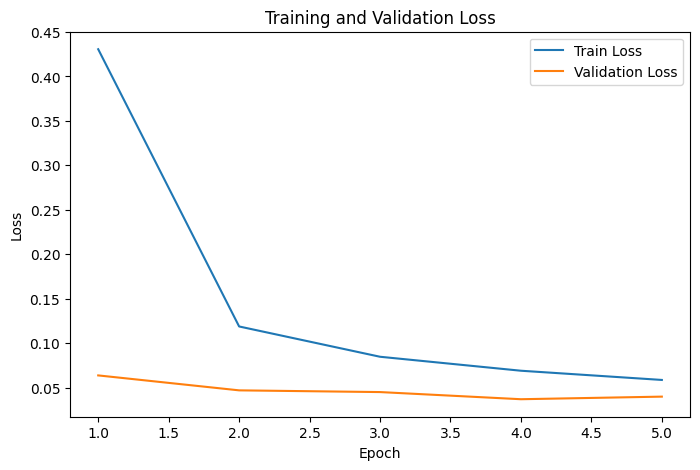


=== Hyperparameter Tuning over DBSCAN + prob_threshold + dist_factor ===
New best: eps=1.5, minS=3, prob=0.6, distF=1.0, valAcc=41.60%
New best: eps=1.5, minS=3, prob=0.6, distF=1.2, valAcc=42.67%
New best: eps=1.5, minS=5, prob=0.6, distF=1.0, valAcc=57.30%
New best: eps=1.5, minS=5, prob=0.6, distF=1.2, valAcc=58.83%
New best: eps=2.0, minS=3, prob=0.6, distF=1.0, valAcc=73.05%
New best: eps=2.0, minS=3, prob=0.6, distF=1.2, valAcc=73.52%
New best: eps=2.0, minS=5, prob=0.6, distF=1.0, valAcc=84.83%
New best: eps=2.0, minS=5, prob=0.6, distF=1.2, valAcc=85.52%
New best: eps=2.5, minS=3, prob=0.6, distF=1.0, valAcc=86.71%
New best: eps=2.5, minS=3, prob=0.6, distF=1.2, valAcc=86.84%
New best: eps=2.5, minS=5, prob=0.6, distF=1.0, valAcc=93.86%
New best: eps=2.5, minS=5, prob=0.6, distF=1.2, valAcc=94.21%
New best: eps=2.5, minS=5, prob=0.7, distF=1.2, valAcc=94.22%

Best config = eps=2.5, min_samples=5, prob=0.7, dist_factor=1.2, valAcc=94.22%

=== Final OSR (with best config) on Tes

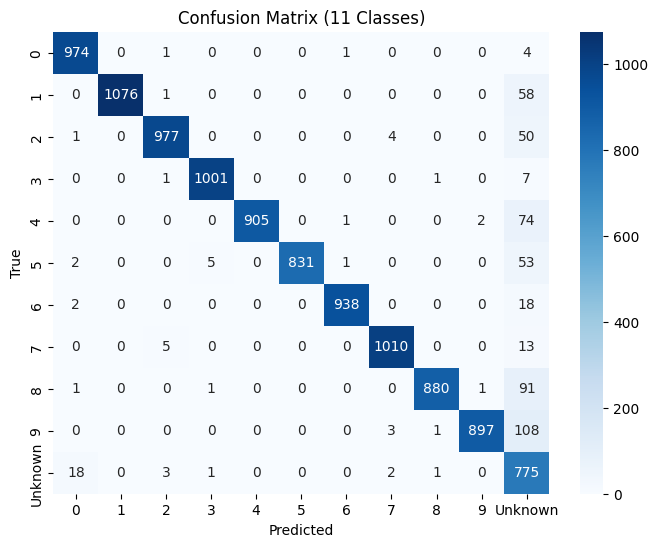

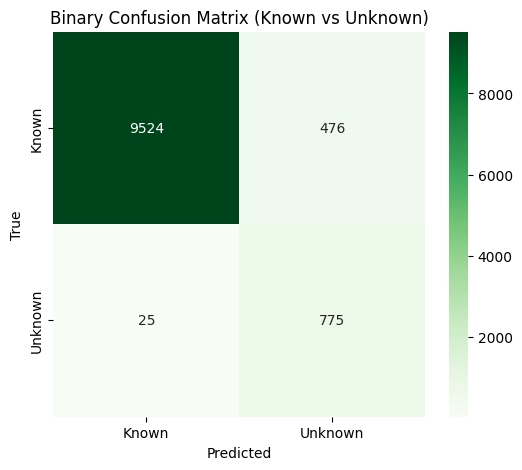

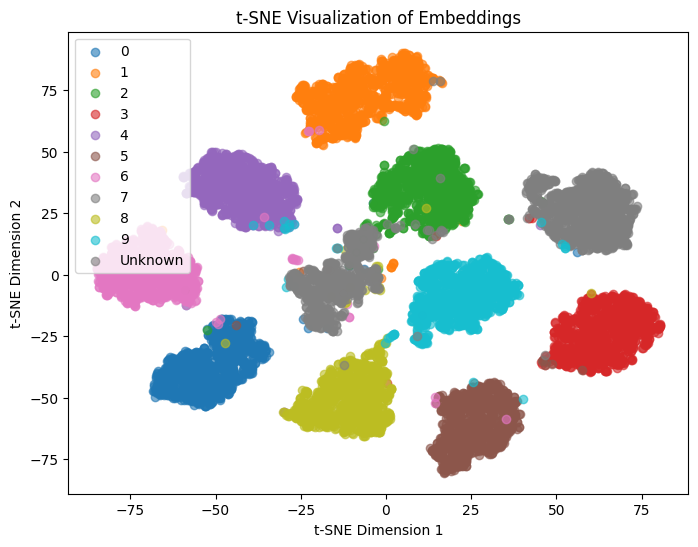

Done.


In [2]:
#%%
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision.datasets import MNIST, CIFAR10, FashionMNIST
from torchvision import transforms
import numpy as np
import random
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#%%
# Basic Definitions and Setup
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

eval_mode = False       # Set to True for evaluation only
epochs = 5              # Adjust as needed (should be under 10 minutes)
lr = 1e-3
batch_size = 128
embedding_dim = 64
triplet_alpha = 1.0     # Weight for Triplet Loss

# Number of OOD samples for validation and testing
num_ood_val = 300
num_ood_test = 800

#%%
# CombinedDataset: Merges two datasets (in-dist and OOD).
# OOD samples are assigned label 10.
class CombinedDataset(Dataset):
    """
    Merges two datasets (in-dist and OOD) where the OOD samples receive label 10.
    """
    def __init__(self, ds_in, ds_ood):
        self.ds_in = ds_in
        self.ds_ood = ds_ood

    def __len__(self):
        return len(self.ds_in) + len(self.ds_ood)

    def __getitem__(self, idx):
        if idx < len(self.ds_in):
            data, label = self.ds_in[idx]
            return data, label
        else:
            data, _ = self.ds_ood[idx - len(self.ds_in)]
            return data, 10

#%%
def eval_model(model, data_loader, device):
    """
    Evaluates an OSR model that outputs (N, 11) logits (10 known classes + 1 'unknown').
    Returns accuracy on in-dist (MNIST), OOD, and overall.
    """
    model.eval()
    correct_in = 0
    total_in = 0
    correct_ood = 0
    total_ood = 0

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)  # Expected shape (N, 11)
            _, y_pred = torch.max(outputs, dim=1)

            mask_in = (labels < 10)
            mask_ood = (labels == 10)

            labels_in = labels[mask_in]
            labels_ood = labels[mask_ood]
            pred_in = y_pred[mask_in]
            pred_ood = y_pred[mask_ood]

            total_in += labels_in.size(0)
            correct_in += (pred_in == labels_in).sum().item()

            total_ood += labels_ood.size(0)
            correct_ood += (pred_ood == labels_ood).sum().item()

    acc_in = correct_in / total_in if total_in > 0 else 0
    acc_ood = correct_ood / total_ood if total_ood > 0 else 0
    acc_total = (correct_in + correct_ood) / (total_in + total_ood)
    return acc_in, acc_ood, acc_total

#%%
# CNN with Embedding Network and Triplet Loss
class CNN_EmbeddingNet_Triplet(nn.Module):
    def __init__(self, embedding_dim=64, dropout_p=0.3):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers for embedding
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(128, embedding_dim)

        # Classifier for 10 known classes
        self.classifier = nn.Linear(embedding_dim, 10)

    def forward_features(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        emb = self.fc2(x)
        return emb

    def forward_classifier(self, emb):
        return self.classifier(emb)

    def forward_inference_10(self, x):
        emb = self.forward_features(x)
        logits = self.forward_classifier(emb)
        return logits

    def forward(self, x):
        return self.forward_inference_10(x)

#%%
def train_one_epoch_triplet(model, loader, optimizer, ce_criterion, triplet_margin=1.0, alpha=1.0):
    model.train()
    triplet_criterion = nn.TripletMarginLoss(margin=triplet_margin, reduction='mean')

    running_loss = 0.0
    running_ce = 0.0
    running_trip = 0.0
    total_samples = 0
    correct = 0

    for data, labels in loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass for classification
        logits = model.forward_inference_10(data)
        ce_loss = ce_criterion(logits, labels)

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

        # Forward pass for embeddings
        emb = model.forward_features(data)

        # Create triplets for triplet loss
        anchor_list, pos_list, neg_list = [], [], []
        label2indices = {}
        for i, lab in enumerate(labels):
            lab_i = lab.item()
            label2indices.setdefault(lab_i, []).append(i)

        for i, lab in enumerate(labels):
            anchor_label = lab.item()
            if len(label2indices[anchor_label]) < 2:
                continue
            pos_idx = i
            while pos_idx == i:
                pos_idx = random.choice(label2indices[anchor_label])
            neg_label = anchor_label
            while neg_label == anchor_label:
                neg_label = random.choice(list(label2indices.keys()))
            neg_idx = random.choice(label2indices[neg_label])

            anchor_list.append(emb[i].unsqueeze(0))
            pos_list.append(emb[pos_idx].unsqueeze(0))
            neg_list.append(emb[neg_idx].unsqueeze(0))

        if len(anchor_list) > 0:
            anchor_t = torch.cat(anchor_list, dim=0)
            pos_t = torch.cat(pos_list, dim=0)
            neg_t = torch.cat(neg_list, dim=0)
            trip_loss = triplet_criterion(anchor_t, pos_t, neg_t)
        else:
            trip_loss = torch.tensor(0.0, device=device)

        total_loss = ce_loss + alpha * trip_loss
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item() * data.size(0)
        running_ce += ce_loss.item() * data.size(0)
        running_trip += trip_loss.item() * data.size(0)

    ep_loss = running_loss / total_samples
    ep_ce = running_ce / total_samples
    ep_trip = running_trip / total_samples
    ep_acc = correct / total_samples
    return ep_loss, ep_ce, ep_trip, ep_acc

#%%
def evaluate_classifier(model, loader, ce_criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in loader:
            data, labels = data.to(device), labels.to(device)
            logits = model.forward_inference_10(data)
            ce_loss = ce_criterion(logits, labels)
            total_loss += ce_loss.item() * data.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

#%%
def compute_dbscan_clusters(model, dataset, eps, min_samples):
    """
    For each class (0..9), gather embeddings and run DBSCAN (with eps and min_samples).
    Returns a dictionary mapping class -> list of clusters (each cluster has a centroid and a radius).
    """
    model.eval()
    label2vecs = {c: [] for c in range(10)}

    loader = DataLoader(dataset, batch_size=256, shuffle=False)
    with torch.no_grad():
        for data, labels in loader:
            data, labels = data.to(device), labels.to(device)
            emb = model.forward_features(data)
            emb_np = emb.cpu().numpy()  # shape (B, embedding_dim)
            for i, lab in enumerate(labels):
                label2vecs[lab.item()].append(emb_np[i])

    dbscan_dict = {}
    for c in range(10):
        arr = np.vstack(label2vecs[c])
        if len(arr) == 0:
            dbscan_dict[c] = []
            continue
        dbs = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbs.fit_predict(arr)
        clusters_info = []
        unique_labels = set(cluster_labels) - {-1}
        for clab in unique_labels:
            points = arr[cluster_labels == clab]
            centroid = points.mean(axis=0)
            dists = np.sqrt(((points - centroid) ** 2).sum(axis=1))
            radius = dists.max()
            clusters_info.append({"centroid": centroid, "radius": radius})
        dbscan_dict[c] = clusters_info
    return dbscan_dict

#%%
class OSRWrapperDBSCAN(nn.Module):
    def __init__(self, core_model, dbscan_dict, prob_threshold=0.7, dist_factor=1.0):
        """
        1) If max probability < prob_threshold, classify as unknown.
        2) Otherwise, for the predicted class, check the distance of the sample's embedding
           to the nearest cluster. If the distance exceeds (radius * dist_factor), mark as unknown.
        """
        super().__init__()
        self.core_model = core_model
        self.dbscan_dict = dbscan_dict
        self.prob_threshold = prob_threshold
        self.dist_factor = dist_factor

    def forward(self, x):
        emb = self.core_model.forward_features(x)
        logits_10 = self.core_model.forward_classifier(emb)
        probs_10 = F.softmax(logits_10, dim=1)

        # Prepare output logits for 11 classes: copy known class logits and reserve slot 10 for unknown.
        out_11 = torch.zeros(x.size(0), 11, device=x.device)
        out_11[:, :10] = logits_10

        max_probs, pred_class = torch.max(probs_10, dim=1)
        emb_np = emb.detach().cpu().numpy()

        for i in range(x.size(0)):
            p = max_probs[i].item()
            c = pred_class[i].item()
            if p < self.prob_threshold:
                out_11[i, c] = -10.0
                out_11[i, 10] = 10.0
                continue

            clusters_info = self.dbscan_dict[c]
            if len(clusters_info) == 0:
                out_11[i, c] = -10.0
                out_11[i, 10] = 10.0
                continue

            sample_emb = emb_np[i]
            min_dist = 1e9
            best_radius = 0.0
            for info in clusters_info:
                centroid = info["centroid"]
                radius = info["radius"]
                dist = np.sqrt(((sample_emb - centroid) ** 2).sum())
                if dist < min_dist:
                    min_dist = dist
                    best_radius = radius
            if min_dist > best_radius * self.dist_factor:
                out_11[i, c] = -10.0
                out_11[i, 10] = 10.0
            else:
                out_11[i, 10] = -10.0

        return out_11

#%%
# Data Transforms
# For MNIST (in-distribution)
transform_mnist_train = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
transform_mnist_test = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# For CIFAR10 (OOD): convert RGB to grayscale, resize, and normalize
transform_cifar = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

#%%
# Load MNIST as in-distribution data
mnist_train_full = MNIST(root='./data', train=True, download=True, transform=transform_mnist_train)
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform_mnist_test)

# Create a validation split from MNIST training data (90%-10%)
val_ratio = 0.1
train_size = int((1 - val_ratio) * len(mnist_train_full))
val_size = len(mnist_train_full) - train_size
mnist_train_ds, mnist_val_ds = random_split(
    mnist_train_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)
mnist_val_ds.dataset.transform = transform_mnist_test

train_loader = DataLoader(mnist_train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mnist_val_ds, batch_size=batch_size, shuffle=False)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

#%%
# Load CIFAR10 as OOD data using CIFAR transform
# cifar_test = CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
cifar_test = FashionMNIST(root='./data', train=False, download=True, transform=transform_cifar)

inds = list(range(len(cifar_test)))
random.shuffle(inds)
inds_ood_val = inds[:num_ood_val]
inds_ood_test = inds[num_ood_val : num_ood_val + num_ood_test]

cifar_ood_val_ds = Subset(cifar_test, inds_ood_val)
cifar_ood_test_ds = Subset(cifar_test, inds_ood_test)

# Create combined datasets for OSR evaluation (in-dist + OOD)
val_ood_ds = CombinedDataset(mnist_val_ds, cifar_ood_val_ds)
test_ood_ds = CombinedDataset(mnist_test, cifar_ood_test_ds)

val_ood_loader = DataLoader(val_ood_ds, batch_size=256, shuffle=False)
test_ood_loader = DataLoader(test_ood_ds, batch_size=256, shuffle=False)

print("Datasets loaded. MNIST + FashionMNIST as OOD.")

#%%
# Initialize core model and optimizer
core_model = CNN_EmbeddingNet_Triplet(embedding_dim=embedding_dim, dropout_p=0.3).to(device)
optimizer = optim.Adam(core_model.parameters(), lr=lr)
ce_criterion = nn.CrossEntropyLoss()

# Lists to store training and validation losses for plotting
train_losses = []
val_losses = []

if not eval_mode:
    print("=== Training CNN Embedding Model (Triplet + CE) on MNIST ===")
    for ep in range(1, epochs + 1):
        total_loss, ce_loss_val, trip_loss_val, train_acc = train_one_epoch_triplet(
            core_model, train_loader, optimizer, ce_criterion,
            triplet_margin=1.0, alpha=triplet_alpha
        )
        val_loss, val_acc = evaluate_classifier(core_model, val_loader, ce_criterion)
        train_losses.append(total_loss)
        val_losses.append(val_loss)
        print(f"Epoch {ep}/{epochs} | TrainLoss={total_loss:.4f} (CE={ce_loss_val:.4f}, T={trip_loss_val:.4f}), Acc={train_acc:.4f} | ValLoss={val_loss:.4f}, ValAcc={val_acc:.4f}")
    torch.save(core_model.state_dict(), "mnist_cnn_triplet_dbscan_tuning.pth")
    print("Saved weights to mnist_cnn_triplet_dbscan_tuning.pth")
else:
    core_model.load_state_dict(torch.load("mnist_cnn_triplet_dbscan_tuning.pth", map_location=device))
    print("Loaded weights from mnist_cnn_triplet_dbscan_tuning.pth")

#%%
# Plot Training and Validation Losses (if training was performed)
if not eval_mode:
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

#%%
# Hyperparameter tuning for DBSCAN + probability threshold + distance factor
eps_grid = [1.5, 2.0, 2.5]
min_samples_grid = [3, 5]
prob_grid = [0.6, 0.7, 0.8]
dist_factor_grid = [1.0, 1.2]

best_config = None
best_acc = 0.0

print("\n=== Hyperparameter Tuning over DBSCAN + prob_threshold + dist_factor ===")
for eps_val in eps_grid:
    for min_s in min_samples_grid:
        # Compute DBSCAN clusters for this combination using the MNIST training set
        dbscan_dict = compute_dbscan_clusters(core_model, mnist_train_ds, eps=eps_val, min_samples=min_s)
        for prob_t in prob_grid:
            for dist_f in dist_factor_grid:
                temp_model = OSRWrapperDBSCAN(
                    core_model,
                    dbscan_dict,
                    prob_threshold=prob_t,
                    dist_factor=dist_f
                ).to(device)
                acc_in, acc_ood, acc_total = eval_model(temp_model, val_ood_loader, device)
                if acc_total > best_acc:
                    best_acc = acc_total
                    best_config = (eps_val, min_s, prob_t, dist_f)
                    print(f"New best: eps={eps_val}, minS={min_s}, prob={prob_t}, distF={dist_f}, valAcc={acc_total*100:.2f}%")

eps_best, min_s_best, prob_best, dist_f_best = best_config
print(f"\nBest config = eps={eps_best}, min_samples={min_s_best}, prob={prob_best}, dist_factor={dist_f_best}, valAcc={best_acc*100:.2f}%")

#%%
# Compute final DBSCAN clusters with the best config and evaluate on the test set
dbscan_dict_final = compute_dbscan_clusters(core_model, mnist_train_ds, eps=eps_best, min_samples=min_s_best)
final_model = OSRWrapperDBSCAN(core_model, dbscan_dict_final, prob_threshold=prob_best, dist_factor=dist_f_best).to(device)

acc_in_test, acc_ood_test, acc_total_test = eval_model(final_model, test_ood_loader, device)
print("\n=== Final OSR (with best config) on Test Set ===")
print(f"Accuracy on MNIST (in-dist): {acc_in_test*100:.2f}%")
print(f"Accuracy on OOD:            {acc_ood_test*100:.2f}%")
print(f"Overall Accuracy:           {acc_total_test*100:.2f}%")

#%%
# Additional Plots for Analysis
# 1. Confusion Matrix for 11 classes (0-9 + Unknown)
final_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data, labels in test_ood_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = final_model(data)
        _, preds = torch.max(outputs, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm_11 = confusion_matrix(all_labels, all_preds, labels=list(range(10)) + [10])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_11, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(range(10)) + ['Unknown'],
            yticklabels=list(range(10)) + ['Unknown'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (11 Classes)')
plt.show()

# 2. Binary Confusion Matrix (Known vs Unknown)
binary_preds = np.where(all_preds < 10, 0, 1)
binary_labels = np.where(all_labels < 10, 0, 1)
cm_bin = confusion_matrix(binary_labels, binary_preds, labels=[0, 1])
plt.figure(figsize=(6, 5))
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Known', 'Unknown'],
            yticklabels=['Known', 'Unknown'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Binary Confusion Matrix (Known vs Unknown)')
plt.show()

# 3. t-SNE Visualization of Embeddings from Test Set
all_embeddings = []
all_labels_emb = []
with torch.no_grad():
    for data, labels in test_ood_loader:
        data, labels = data.to(device), labels.to(device)
        emb = final_model.core_model.forward_features(data)
        all_embeddings.append(emb.cpu().numpy())
        all_labels_emb.append(labels.cpu().numpy())
all_embeddings = np.concatenate(all_embeddings)
all_labels_emb = np.concatenate(all_labels_emb)

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(8, 6))
colors = plt.cm.tab10(np.linspace(0, 1, 10))
colors = np.vstack([colors, np.array([0.5, 0.5, 0.5, 1])])  # Color for Unknown
for label in np.unique(all_labels_emb):
    idx = all_labels_emb == label
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1],
                color=colors[label] if label < 10 else colors[-1],
                label=str(label) if label < 10 else 'Unknown',
                alpha=0.6)
plt.legend()
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

print("Done.")
